# Segmentation of Indian Traffic

In [1]:
!pip install pyunpack
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.6 MB/s 


In [2]:
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip3 install -U segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 516.2 MB 3.8 kB/s 
     |████████████████████████████████| 3.0 MB 53.8 MB/s 
     |████████████████████████████████| 454 kB 69.9 MB/s 
     |████████████████████████████████| 26.1 MB 1.4 MB/s 
     |████████████████████████████████| 2.9 MB 47.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Unins

In [3]:
import os
from os import path
import pandas as pd
import numpy as np
import json
import math 
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
from PIL import ImagePath 
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import cv2
import imgaug.augmenters as iaa
import tensorflow as tf
import shutil 
import random
from tqdm import tqdm
import urllib
import zipfile
from pyunpack import Archive 

from tensorflow.keras.utils import get_source_inputs
import segmentation_models as sm
from segmentation_models import Unet

from segmentation_models.metrics import iou_score
import keras

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Archive('/content/drive/MyDrive/data.zip').extractall('/content')
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data.zip", 'r')
#zip_ref.extractall("/tmp")
#zip_ref.close()

Mounted at /content/drive


In [5]:
dir_path = "/content"
file_names = set()
for i in os.listdir(dir_path):
    file_names.add(i.split('.')[0])

In [6]:
file_names

{'', 'data', 'drive', 'sample_data'}

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [7]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    df = pd.DataFrame()
    for i in os.listdir(root_dir):
      lst = []
      path1 = os.path.join(root_dir, i)
      print(path1)
      for j in sorted(os.listdir(path1)):
        path2 = os.path.join(path1, j)
        for k in sorted(os.listdir(path2)):
          path3 = os.path.join(path2, k)
          lst.append(path3)
      df[i] = lst
    return df

In [8]:
root_dir = '/content/data'
data_df = return_file_names_df(root_dir)
data_df.rename(columns = {'mask':'json'}, inplace = True)

/content/data/images
/content/data/mask


In [9]:
print(data_df.head().to_string())

                                               images                                                   json
0  /content/data/images/201/frame0029_leftImg8bit.jpg  /content/data/mask/201/frame0029_gtFine_polygons.json
1  /content/data/images/201/frame0299_leftImg8bit.jpg  /content/data/mask/201/frame0299_gtFine_polygons.json
2  /content/data/images/201/frame0779_leftImg8bit.jpg  /content/data/mask/201/frame0779_gtFine_polygons.json
3  /content/data/images/201/frame1019_leftImg8bit.jpg  /content/data/mask/201/frame1019_gtFine_polygons.json
4  /content/data/images/201/frame1469_leftImg8bit.jpg  /content/data/mask/201/frame1469_gtFine_polygons.json


> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [10]:

def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][20:i[0].find('_')]==i[1][18:i[1].find('_')]):
            return False
    return True

In [11]:
grader_1(data_df)

True

In [12]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [13]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels = set()
    for file in data_df['json']:
      data_file = open(file)
      data = json.load(data_file)
      for val in data['objects']:
        unique_labels.add(val['label'])
    return unique_labels

In [14]:
unique_labels = return_unique_labels(data_df)
unique_labels

{'animal',
 'autorickshaw',
 'bicycle',
 'billboard',
 'bridge',
 'building',
 'bus',
 'car',
 'caravan',
 'curb',
 'drivable fallback',
 'ego vehicle',
 'fallback background',
 'fence',
 'ground',
 'guard rail',
 'motorcycle',
 'non-drivable fallback',
 'obs-str-bar-fallback',
 'out of roi',
 'parking',
 'person',
 'pole',
 'polegroup',
 'rail track',
 'rectification border',
 'rider',
 'road',
 'sidewalk',
 'sky',
 'traffic light',
 'traffic sign',
 'trailer',
 'train',
 'truck',
 'tunnel',
 'unlabeled',
 'vegetation',
 'vehicle fallback',
 'wall'}

In [15]:
len(unique_labels)

40

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [16]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [17]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [18]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    label = []
    vertexlist = []
    vertex = []

    
    f = open(file)
    Data = json.load(f)
    w = Data['imgWidth']
    h = Data['imgHeight']

    
    
    for obj in Data['objects']:
        label.append(obj['label'])
        vertex.append(obj['polygon'])

    
    for each in vertex:
        vertexlist.append([tuple(i) for i in each])

    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    
    f.close()
    vertex.clear()
    return w, h, label, vertexlist

In [19]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len(vertexlist))
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

227
True


## 4. Creating Image segmentations by drawing set of polygons

### Example

In [20]:
img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
print(img1)

(28, 28, 3)
[[0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0]
 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0]
 [0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

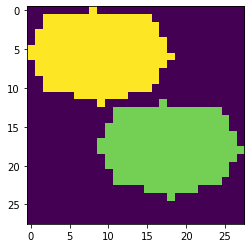

In [21]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]


img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =38)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [22]:
root_dir

'/content/data'

In [23]:
out_dir = '/content/data/output'
out_dir

'/content/data/output'

In [24]:
os.mkdir(out_dir)

In [25]:
for i in os.listdir('/content/data'):
    print(i.split('.')[0])

images
mask
output


In [26]:
#out_dir = '/content/data/output'
#os.mkdir(out_dir)

In [27]:
import os, shutil
for files in os.listdir(out_dir):
    path = os.path.join(out_dir, files)
    try:
        shutil.rmtree(path)
    except OSError:
        os.remove(path)

In [28]:
print(data_df.head().to_string())

                                               images                                                   json
0  /content/data/images/201/frame0029_leftImg8bit.jpg  /content/data/mask/201/frame0029_gtFine_polygons.json
1  /content/data/images/201/frame0299_leftImg8bit.jpg  /content/data/mask/201/frame0299_gtFine_polygons.json
2  /content/data/images/201/frame0779_leftImg8bit.jpg  /content/data/mask/201/frame0779_gtFine_polygons.json
3  /content/data/images/201/frame1019_leftImg8bit.jpg  /content/data/mask/201/frame1019_gtFine_polygons.json
4  /content/data/images/201/frame1469_leftImg8bit.jpg  /content/data/mask/201/frame1469_gtFine_polygons.json


In [29]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    #out_dir = os.path.join(root_dir, '/output')
    #os.mkdir(out_dir)
    n = []
    output_path = '/content/data/output'
    final_path = os.path.join(output_path, '201')
    os.mkdir(final_path)
    n.append('201')
    for files in tqdm(data_df['json'].values):
        
        w, h, labels, vertexlist = get_poly(files)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        n.append(files[19:22])
        final_path = os.path.join(output_path, files[19:22])
        if (n[-2] != n[-1]):
            os.mkdir(final_path)
        
        for i in range(0,len(labels)):
            if len(vertexlist[i])>1:
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])

        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        im.save(os.path.join(final_path, files[23:-5]+".png"))
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    # The obtained mask path is appended in the dataframe.
    M = []
    for folder in os.listdir(output_path):
        for m in os.listdir(os.path.join(output_path, folder)):
            path = os.path.join(output_path, folder, m)
            M.append(path)

    data_df['mask'] = sorted(M)
    return data_df

In [30]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [03:58<00:00, 16.81it/s]


,images,json,mask
0,/content/data/images/201/frame0029_leftImg8bit...,/content/data/mask/201/frame0029_gtFine_polygo...,/content/data/output/201/frame0029_gtFine_poly...
1,/content/data/images/201/frame0299_leftImg8bit...,/content/data/mask/201/frame0299_gtFine_polygo...,/content/data/output/201/frame0299_gtFine_poly...
2,/content/data/images/201/frame0779_leftImg8bit...,/content/data/mask/201/frame0779_gtFine_polygo...,/content/data/output/201/frame0779_gtFine_poly...
3,/content/data/images/201/frame1019_leftImg8bit...,/content/data/mask/201/frame1019_gtFine_polygo...,/content/data/output/201/frame1019_gtFine_poly...
4,/content/data/images/201/frame1469_leftImg8bit...,/content/data/mask/201/frame1469_gtFine_polygo...,/content/data/output/201/frame1469_gtFine_poly...


In [31]:
#daving the final dataframe to a csv file
data_df.to_csv('Segmentation_Assignment_Preprocessed_Data.csv', index=False)

In [32]:
from google.colab import files
files.download('Segmentation_Assignment_Preprocessed_Data.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

#### Reference : https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b

#### Dice loss originates from Sørensen–Dice coefficient, which is a statistic developed in 1940s to gauge the similarity between two samples [Wikipedia]. It was brought to computer vision community by Milletari et al. in 2016 for 3D medical image segmentation.

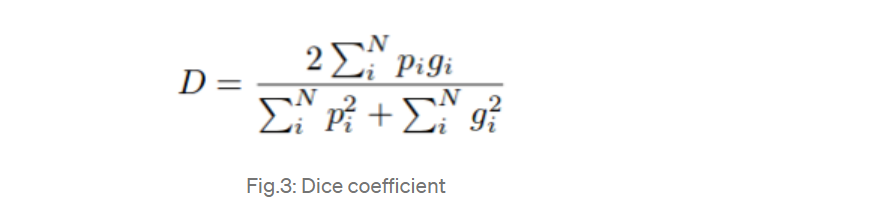

Fig shows the equation of Dice coefficient, in which pi and gi represent pairs of corresponding pixel values of prediction and ground truth, respectively. In boundary detection scenario, the values of pi and gi are either 0 or 1, representing whether the pixel is boundary (value of 1) or not (value of 0). Therefore, the denominator is the sum of total boundary pixels of both prediction and ground truth, and the numerator is the sum of correctly predicted boundary pixels because the sum increments only when pi and gi match (both of value 1).

The range of the loss lies between 0 and 1.

Wherever we have a boundary if that boundary is predicted correctly then only it will increase our numerator whereas denominator increases wherever label is predicted is wrong or boundary is predicted correctly.

That is the reason it works so well.

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [33]:
tf.keras.backend.clear_session()
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [34]:
#%env SM_FRAMEWORK=tf.keras
tf.keras.backend.set_image_data_format('channels_last')

In [35]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
#model = Unet('resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid', input_shape=(512,512,3))

In [36]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

In [37]:
backbone = 'resnet50'
preprocess_input = sm.get_preprocessing(backbone)

In [38]:
# Data Augmentation functions.
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [39]:
# Creating the Batch Dataset for the model.
class Dataset:
    # we will be modifying this CLASSES according to the data/problems
    CLASSES = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes = None):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
        image_mask = mask / 10

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = image
            image_mask = image_mask
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    

In [40]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [41]:
X_train, X_test = train_test_split(data_df, test_size = 0.2)
X_train.shape, X_test.shape

((3206, 3), (802, 3))

In [42]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
BATCH_SIZE = 8
IMAGE_SHAPE = (256, 256, 3)
n_classes = len(CLASSES)

In [43]:
train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)

In [44]:
train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [45]:
print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

(8, 256, 256, 3)


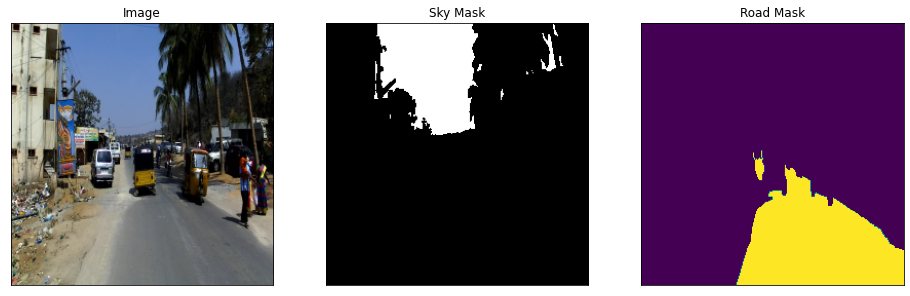

In [46]:
img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, 16], road_mask = mas[:, :, 1])

In [47]:
%env SM_FRAMEWORK=tf.keras
!pip install keras==2.3.1

env: SM_FRAMEWORK=tf.keras
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

'tf.keras'

In [81]:
model = Unet(backbone_name = backbone, input_shape = IMAGE_SHAPE, classes = n_classes, activation = 'softmax', encoder_freeze = True,
             encoder_weights = 'imagenet', decoder_block_type = 'upsampling')

In [82]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [76]:
# Dice loss
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [77]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only = True, save_best_only = True, \
                                       mode = 'max', monitor = 'val_iou_score', verbose = 1),
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 1, mode = 'max', verbose = 1),
]

In [78]:
train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE
len(train_dataloader), train_steps

(200, 400)

In [79]:
#opt=keras.optimizers.Adam(0.0001)
#model.compile(optimizer=opt, loss=sm.losses.bce_jaccard_loss, metrics=[iou_score])

# Dice loss
#optim = keras.optimizers.Adam(0.0001)
#focal_loss = sm.losses.cce_dice_loss
#model.compile(optim, focal_loss, metrics=[iou_score])

In [80]:
import tensorflow as tf
# tf.enable_eager_execution()
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
# import albumentations as A
from keras import legacy

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [56]:
# import tensorflow as tf
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [57]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
from tensorflow.keras.models import Model, load_model
model = Unet('vgg16', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))

58892288/58889256 [==============================] - 2s 0us/step


In [58]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [59]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
#iou_score = sm.metrics.IOUScore(threshold = 0.5)
model.compile(optim, focal_loss, metrics=[iou_score])

In [60]:
CLASSES = list(np.unique(list(label_clr.values())))

In [83]:

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self , basepath , images_file_names , mask_file_names , CLASSES):
        
        self.image_ids = images_file_names
        self.mask_ids = mask_file_names     
        # the paths of images
        self.images_fps   = [os.path.join(basepath,image_id) for image_id in self.image_ids]

        # the paths of segmentation images
        self.masks_fps    = [os.path.join(basepath,mask_id) for mask_id in self.mask_ids]

        # giving labels for each class
        self.CLASSES= CLASSES
        self.class_values = CLASSES
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask,(256,256))
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        if self.images_fps[i] in X_train:
          a = np.random.uniform()
          if a<0.2:
              image = aug2.augment_image(image)
              image_mask = aug2.augment_image(image_mask)
          elif a<0.4:
              image = aug3.augment_image(image)
              image_mask = aug3.augment_image(image_mask)
          elif a<0.6:
              image = aug4.augment_image(image)
              image_mask = aug4.augment_image(image_mask)
          elif a<0.8:
              image = aug5.augment_image(image)
              image_mask = image_mask
          else:
              image = aug6.augment_image(image)
              image_mask = aug6.augment_image(image_mask)
              
        return image, image_mask
        
    def __len__(self):
        return len(self.image_ids)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [86]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.dice_loss
#iou_score = sm.metrics.IOUScore(threshold = 0.5)
model.compile(optim, focal_loss, metrics=[iou_score])

In [87]:
CLASSES = list(np.unique(list(label_clr.values())))

In [88]:
from keras.callbacks import Callback, ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.callbacks import TensorBoard
import time
# import datetime
!rm -rf '/content/logs'
CLASSES = CLASSES
basepath = '/content/'
train_dataset = Dataset(basepath, X_train['images'].values, X_train['mask'].values, CLASSES=CLASSES)
test_dataset = Dataset(basepath, X_test['images'].values, X_test['mask'].values, CLASSES=CLASSES)
train_dataloader = Dataloder(train_dataset, batch_size=16, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=16, shuffle=True)
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)
tensorboard = TensorBoard(log_dir="/content/logs/{}".format(time.time()), histogram_freq=1, write_graph=True,write_grads=True)
checkpoint = ModelCheckpoint('./best_model.h5', save_weights_only=True,save_best_only=True, mode='min', monitor='val_iou_score')
red = ReduceLROnPlateau(monitor='val_iou_score', min_lr=0.000001,patience=2)
call = [tensorboard]

(16, 256, 256, 3)
(16, 256, 256, 21)


/usr/local/lib/python3.7/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [ ]:
history = model.fit_generator(train_dataloader, steps_per_epoch = train_steps, epochs = 50,\
                              validation_data = val_dataloader, validation_steps = valid_steps,
                              callbacks = callbacks)

Epoch 1/50
400/400 [==============================] - 361s 903ms/step - loss: 0.7722 - iou_score: 0.2107 - val_loss: 0.7574 - val_iou_score: 0.2357

Epoch 00001: val_iou_score improved from 0.15943 to 0.23567, saving model to ./best_model.h5
Epoch 2/50
400/400 [==============================] - 335s 837ms/step - loss: 0.6977 - iou_score: 0.2674 - val_loss: 0.6722 - val_iou_score: 0.2795

Epoch 00002: val_iou_score improved from 0.23567 to 0.27952, saving model to ./best_model.h5
Epoch 3/50
400/400 [==============================] - 334s 836ms/step - loss: 0.6394 - iou_score: 0.3127 - val_loss: 0.6635 - val_iou_score: 0.3196

Epoch 00003: val_iou_score improved from 0.27952 to 0.31958, saving model to ./best_model.h5
Epoch 4/50
400/400 [==============================] - 336s 841ms/step - loss: 0.6082 - iou_score: 0.3400 - val_loss: 0.6218 - val_iou_score: 0.3394

Epoch 00004: val_iou_score improved from 0.31958 to 0.33935, saving model to ./best_model.h5
Epoch 5/50
400/400 [============

# Task 3: Training CANet

In [114]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import concatenate
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [115]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=2, name="conv block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        #first conv Layer
        self.conv1 = Conv2D(self.F1,kernel_size = (1,1),strides=(self.stride,self.stride),padding = 'same')
        
        #sec conv layer
        self.conv2 =  Conv2D(self.F2,kernel_size = (3,3),padding = 'same')#strides=(self.stride,self.stride),

        #third conv layer
        self.conv3 =  Conv2D(self.F3,kernel_size = (1,1))#,strides=(self.stride,self.stride),padding = 'same'


        #batch Normalization 
        self.BN1 = BatchNormalization()
        self.BN2 = BatchNormalization()
        self.BN3 = BatchNormalization()
        self.BN4 = BatchNormalization()

        #activationLayer 
        self.actv = Activation('relu')

        #parallel convolution Layer
        self.parallel_conv = Conv2D(self.F3,kernel_size=(3,3),strides=(self.stride,self.stride),padding='same')

        self.add = Add()
    
    def call(self, X):
        # write the architecutre that was mentioned above
        
        Y = self.parallel_conv(X)
        Y = self.BN1(Y)
        Y = self.actv(Y)

        X = self.conv1(X)
        X = self.BN2(X)
        X = self.actv(X)

        X = self.conv2(X)
        X = self.BN3(X)
        X = self.actv(X)

        X = self.conv3(X)
        X = self.BN4(X)

        X = self.add([X,Y])
        X = self.actv(X)

        return X

In [116]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride = 2, name="identity block"):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride

        #first conv Layer
        self.conv1 = Conv2D(self.F1,kernel_size = (1,1),strides=(self.stride,self.stride),padding = 'valid')

        #sec conv layer
        self.conv2 =  Conv2D(self.F2,kernel_size = (3,3),padding = 'same')#,strides=(self.stride,self.stride)

        #third conv layer
        self.conv3 =  Conv2D(self.F3,kernel_size = (1,1),padding = 'valid')#,strides=(self.stride,self.stride)

        #batch Normalization 
        self.BN1 = BatchNormalization()
        self.BN2 = BatchNormalization()
        self.BN3 = BatchNormalization()

        #activationLayer 
        self.actv = Activation('relu')

        self.add = Add()
    
    def call(self, X):
        # write the architecutre that was mentioned above
        Y = X

        X = self.conv1(X)
        X = self.BN1(X)
        X = self.actv(X)

        X = self.conv2(X)
        X = self.BN2(X)
        X = self.actv(X)

        X = self.conv3(X)
        X = self.BN3(X)

        X = self.add([X,Y])
        X = self.actv(X)

        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [117]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__(name=name)
        self.globalPoolingAvg = GlobalAveragePooling2D()
        self.BN = BatchNormalization()
        self.actv = Activation('relu')
        self.conv = Conv2D(64,kernel_size=(1,1),padding='same')
        self.upsample = UpSampling2D(size=(32,32),interpolation='bilinear')


        
    def call(self, X):
        X = self.globalPoolingAvg(X)
        X = tf.expand_dims(X,axis=1)
        X = tf.expand_dims(X,axis=1)
        X = self.BN(X)

        X = self.actv(X)

        X = self.conv(X)
        X = self.upsample(X)

        return X

In [118]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        self.concat = Concatenate()
        self.avgPool = AveragePooling2D(pool_size=(2,2))
        self.conv1 = Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv2 = Conv2D(64,kernel_size=(3,3),padding='same')
        self.conv3 = Conv2D(64,kernel_size=(1,1),padding='same')
        self.conv4 = Conv2D(64,kernel_size=(1,1),padding='same')
        self.rel = Activation('relu')
        self.sigm = Activation('sigmoid')
        self.upSample = UpSampling2D(size=(2,2),interpolation='bilinear')
        self.add = Add()
        self.mult =Multiply()

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        # implement the context flow as mentioned in the above cell

        X = self.concat([INP,FLOW])
        X = self.avgPool(X)
        X = self.conv1(X)
        Y = self.conv2(X)

        X = self.conv3(Y)
        X = self.rel(X)
        X = self.conv4(X)
        X = self.sigm(X)

        X = self.mult([Y,X])
        
        X = self.add([Y,X])
        
        X = self.upSample(X)


        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [119]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)

        self.conv1 = Conv2D(32 ,kernel_size=(3,3),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.BN = BatchNormalization()
        self.sigm = Activation('sigmoid')
        self.mult =Multiply()
        self.upSample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        Y = self.conv1(X)
        X = self.global_avg_pool(Y)
        X = tf.expand_dims(X, 1)
        X = tf.expand_dims(X, 1)
        X = self.conv2(X)
        X = self.BN(X)
        X = self.sigm(X)
        out = self.mult([X, Y])
        FSM_Conv_T = self.upSample(out)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [120]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)

        self.conv1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv2  = Conv2D(32,kernel_size=(7,1),padding='same')

        self.conv3  = Conv2D(32,kernel_size=(3,3),padding='same')

        self.conv4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv5  = Conv2D(32,kernel_size=(1,7),padding='same')

        self.add = Add()
        
    def call(self, X):
        # please implement the above mentioned architecture
        conv1 = self.conv1(X)
        conv2= self.conv2(conv1)

        # side path
        conv3 = self.conv4(X)
        conv4 = self.conv5(conv3)

        add1 = self.add([conv2,conv4])

        conv5 = self.conv3(add1)

        X = self.add([conv5,add1])
        
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [121]:
tf.keras.backend.clear_session()

In [125]:
X_input = Input(shape=(256,256,3))# If I keep it as 256 then it gives me error as shoen below
# Convolution and identity stage:
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = convolutional_block(kernel=3,filters=[4,4,8],stride= 2,name  = 'conv_block1')(X)
X_C1 = X
X = identity_block(kernel = 3,filters=[4,4,8],stride=1,name='identity_block11')(X)

X = convolutional_block(kernel=3,filters=[8,8,16],stride= 2,name  = 'conv_block2')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block21')(X)
X = identity_block(kernel = 3,filters=[8,8,16],stride=1,name='identity_block22')(X)

X = convolutional_block(kernel=3,filters=[16,16,32],stride= 1,name  = 'conv_block3')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block31')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block32')(X)
X = identity_block(kernel = 3,filters=[16,16,32],stride=1,name='identity_block33')(X)


X = convolutional_block(kernel=3,filters=[32,32,64],stride= 1,name  = 'conv_block4')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block41')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block42')(X)
X = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block43')(X)
X_id4 = identity_block(kernel = 3,filters=[32,32,64],stride=1,name='identity_block44')(X)



X = global_flow(name = 'global_flow')(X_id4)
X_GF = X
X_CF1 = context_flow(name='context_flow1')([X_id4,X_GF])
X_CF2 = context_flow(name='context_flow2')([X_id4,X_CF1])
X_CF3 = context_flow(name='context_flow3')([X_id4,X_CF2])
added = add([X,X_CF1,X_CF2,X_CF3])
X_FSM = fsm(name='fsm_stage')(added)
X_agcn = agcn(name='agcn')(X_C1)
concat = Concatenate()([X_FSM,X_agcn])

# Concat1 =  UpSampling2D(size = (2,2), interpolation='bilinear')(X_FSM) 
# Concat2 = UpSampling2D(size = (2,2), interpolation='bilinear')(X_agcn)
# CF_ = concatenate([Concat1,Concat2])
# print(CF_.shape)
Final1 = Conv2D(21, (3, 3), activation = 'relu', padding = 'same', name = 'FinalBlock1')(concat)

o_Final  = UpSampling2D((4,4), interpolation = 'bilinear')(Final1)

Final = (Activation('softmax'))(o_Final)

model = Model(inputs = X_input, outputs = Final, name='ResNet50')

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [126]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 256, 256, 64  256         ['conv1[0][0]']                  
                                )                                                          

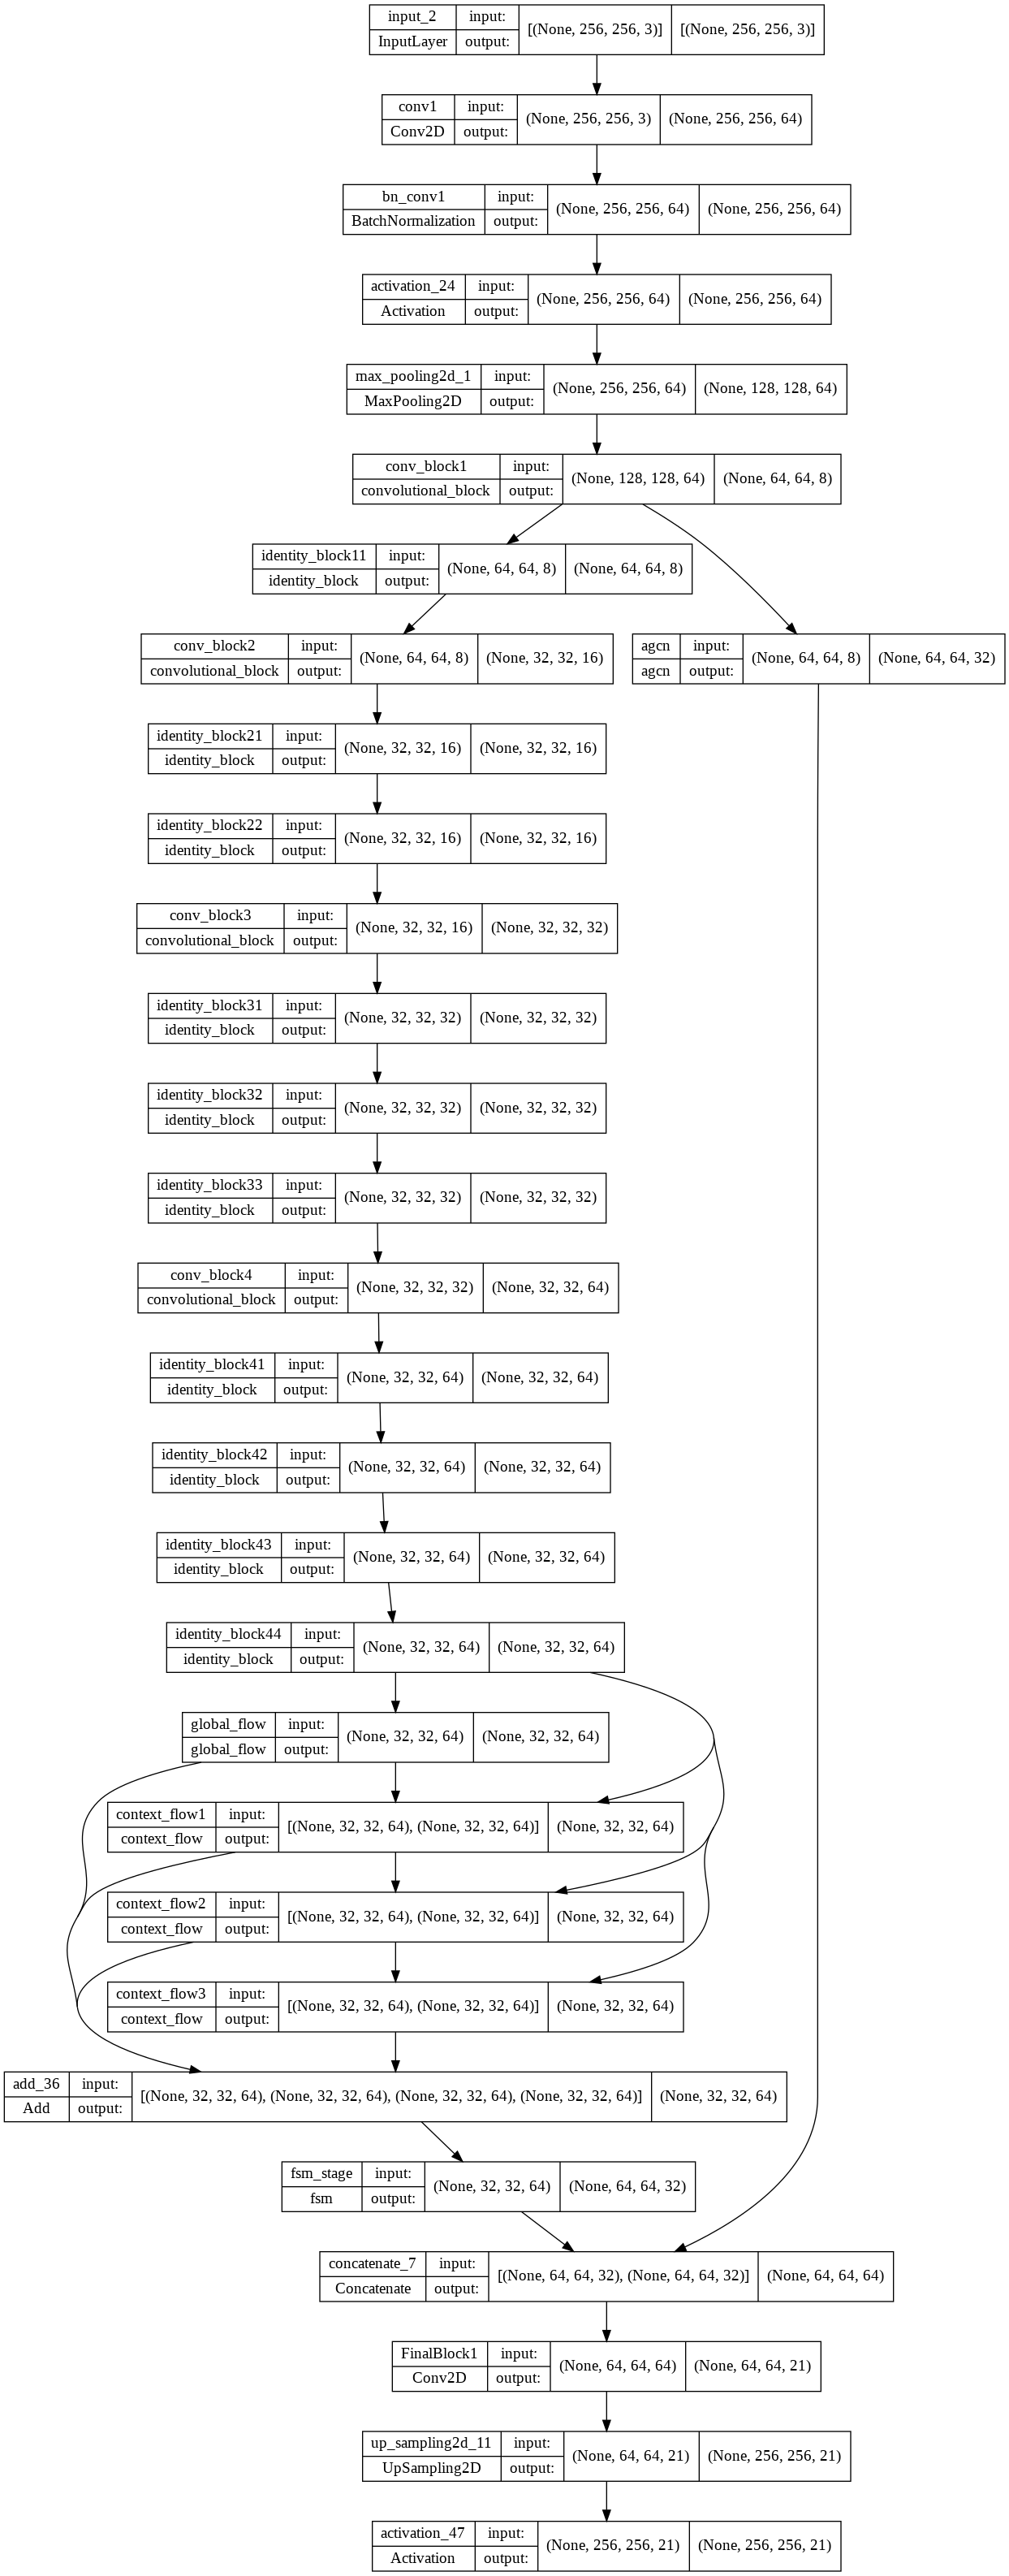

In [127]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [128]:
tf.keras.backend.clear_session()
os.environ["SM_FRAMEWORK"] = "tf.keras"

#%env SM_FRAMEWORK=tf.keras
tf.keras.backend.set_image_data_format('channels_last')


In [129]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()


In [130]:
backbone = 'resnet50'
preprocess_input = sm.get_preprocessing(backbone)

In [131]:
# Data Augmentation functions.
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

# Creating the Batch Dataset for the model.
class Dataset:
    # we will be modifying this CLASSES according to the data/problems
    CLASSES = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    
    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes = None):
        
        self.ids = file_names
        # the paths of images
        self.images_fps   = [image_id for image_id in self.ids['images']]
        # the paths of segmentation images
        self.masks_fps    = [image_id for image_id in self.ids['mask']]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls) for cls in classes]
        
        
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (256, 256),  interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (256, 256),  interpolation = cv2.INTER_AREA)
        image_mask = mask / 10

        
        image_masks = [(image_mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.2:
            image = image
            image_mask = image_mask
        elif a<0.4:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.ids)
    

In [132]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


In [133]:
X_train, X_test = train_test_split(data_df, test_size = 0.2)
X_train.shape, X_test.shape

((3206, 3), (802, 3))

In [134]:
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
BATCH_SIZE = 8
IMAGE_SHAPE = (256, 256, 3)
n_classes = len(CLASSES)

train_dataset = Dataset(X_train, classes=CLASSES)
test_dataset  = Dataset(X_test, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = Dataloder(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

(8, 256, 256, 3)


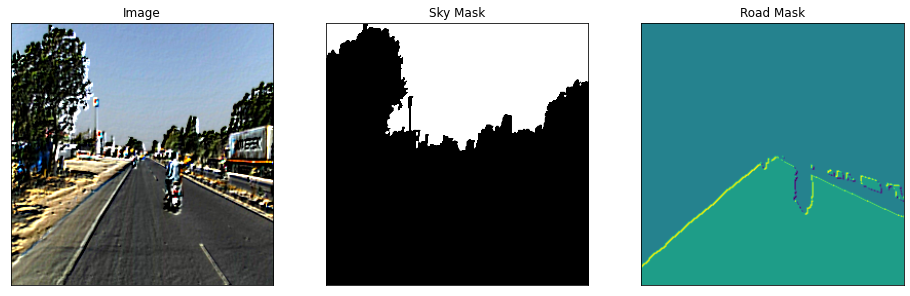

In [135]:
print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, n_classes)

img, mas = train_dataset[51]
visualize(image = img, sky_mask = mas[:, :, 16], road_mask = mas[:, :, 1])

In [136]:
# Dice loss
optim = tf.keras.optimizers.Adam(0.0001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])


In [137]:
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model2.h5', save_weights_only = True, save_best_only = True, \
                                       mode = 'max', monitor = 'val_iou_score', verbose = 1),
    keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 1, mode = 'max', verbose = 1),
]

In [141]:
train_steps = X_train.shape[0]//BATCH_SIZE
valid_steps = X_test.shape[0]//BATCH_SIZE
len(train_dataloader), train_steps

history = model.fit(train_dataloader, steps_per_epoch = train_steps, epochs = 20,\
                              validation_data = val_dataloader, validation_steps = valid_steps,
                              callbacks = callbacks)

Epoch 1/20
400/400 [==============================] - ETA: 0s - loss: 0.8248 - iou_score: 0.1762
Epoch 1: val_iou_score improved from 0.16502 to 0.17165, saving model to ./best_model2.h5
400/400 [==============================] - 306s 764ms/step - loss: 0.8248 - iou_score: 0.1762 - val_loss: 0.8370 - val_iou_score: 0.1716 - lr: 1.0000e-04
Epoch 2/20
400/400 [==============================] - ETA: 0s - loss: 0.8160 - iou_score: 0.1826
Epoch 2: val_iou_score improved from 0.17165 to 0.18861, saving model to ./best_model2.h5
400/400 [==============================] - 303s 757ms/step - loss: 0.8160 - iou_score: 0.1826 - val_loss: 0.8107 - val_iou_score: 0.1886 - lr: 1.0000e-04
Epoch 3/20
400/400 [==============================] - ETA: 0s - loss: 0.8070 - iou_score: 0.1882
Epoch 3: val_iou_score did not improve from 0.18861

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
400/400 [==============================] - 305s 761ms/step - loss: 0.8070 - iou_score: 0.188

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations